## Fundamentals of machine learning
### Attention mechanism and transformers

<br />
December 3, 2024

Source of inspiration: https://github.com/andriygav/MachineLearningSeminars/blob/master/sem18/


## Libraries

In [1]:
!pip install -U transformers~=4.5.1 sentencepiece

  Obtaining dependency information for transformers~=4.5.1 from https://files.pythonhosted.org/packages/d8/b2/57495b5309f09fa501866e225c84532d1fd89536ea62406b2181933fb418/transformers-4.5.1-py3-none-any.whl.metadata
  Using cached transformers-4.5.1-py3-none-any.whl.metadata (41 kB)
  Obtaining dependency information for sentencepiece from https://files.pythonhosted.org/packages/de/42/ae30952c4a0bd773e90c9bf2579f5533037c886dfc8ec68133d5694f4dd2/sentencepiece-0.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached sentencepiece-0.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (7.7 kB)
  Obtaining dependency information for sacremoses from https://files.pythonhosted.org/packages/0b/f0/89ee2bc9da434bd78464f288fdb346bc2932f2ee80a90b2a4bbbac262c74/sacremoses-0.1.1-py3-none-any.whl.metadata
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel .

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import scipy
from transformers import AutoModel, AutoTokenizer
from transformers import MarianMTModel, MarianTokenizer

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Determine the best available device
device = 'mps' if torch.backends.mps.is_available() else        'cuda' if torch.cuda.is_available() else \
         'cpu'
print(f"Using device: {device}")

Using device: mps


## Get parallel texts

In [8]:
import pandas as pd
import requests
import zipfile
import os


def download_wikimatrix_data(src_lang='en', tgt_lang='fr', sample_size=1000):
    """
    Download WikiMatrix parallel sentences for specified language pair
    """
    # Create cache directory if it doesn't exist
    cache_dir = 'wikimatrix_cache'
    os.makedirs(cache_dir, exist_ok=True)

    # Cache file path
    cache_file = f'{cache_dir}/{src_lang}-{tgt_lang}.txt.zip'

    if not os.path.exists(cache_file):
        print(f"Downloading WikiMatrix data for {src_lang}-{tgt_lang}...")
        url = f'https://object.pouta.csc.fi/OPUS-WikiMatrix/v1/moses/{src_lang}-{tgt_lang}.txt.zip'

        try:
            response = requests.get(url)
            response.raise_for_status()

            # Save to cache
            with open(cache_file, 'wb') as f:
                f.write(response.content)

        except Exception as e:
            print(f"Error downloading data: {str(e)}")
            return None

    try:
        # Read ZIP file
        with zipfile.ZipFile(cache_file, 'r') as zip_ref:
            # Get file names in the ZIP
            files = zip_ref.namelist()

            # Find the correct parallel text files
            src_file = next((f for f in files if f.endswith(f'.{src_lang}')), None)
            tgt_file = next((f for f in files if f.endswith(f'.{tgt_lang}')), None)

            if not (src_file and tgt_file):
                print("Could not find parallel text files in the archive")
                return None

            # Read both files
            src_lines = zip_ref.read(src_file).decode('utf-8').splitlines()
            tgt_lines = zip_ref.read(tgt_file).decode('utf-8').splitlines()

            # Create DataFrame
            df = pd.DataFrame({
                f'{src_lang}_text': src_lines[:sample_size],
                f'{tgt_lang}_text': tgt_lines[:sample_size],
                'score': [1.0] * min(len(src_lines), sample_size)  # Default score
            })

            return df

    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None


def filter_parallel_texts(df, min_length=10, max_length=100):
    """
    Filter parallel texts based on length criteria
    """
    if df is None:
        return None

    mask = (
            (df['en_text'].str.len() >= min_length) &
            (df['fr_text'].str.len() >= min_length) &
            (df['en_text'].str.len() <= max_length) &
            (df['fr_text'].str.len() <= max_length)
    )

    return df[mask].reset_index(drop=True)


def analyze_parallel_texts(df):
    """
    Print analysis of parallel texts
    """
    if df is None or df.empty:
        print("No data to analyze")
        return

    print(f"\nTotal number of parallel sentences: {len(df)}")

    print("\nExample parallel sentences:")
    for i, row in df.head(3).iterrows():
        print(f"\nPair {i + 1}:")
        print(f"English: {row['en_text']}")
        print(f"French:  {row['fr_text']}")



In [9]:
from difflib import SequenceMatcher


def is_english_text(text):
    """
    Check if text is likely English based on character frequency
    """
    # Common English characters and patterns
    english_chars = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')
    text_chars = set(text.lower())

    # Calculate ratio of English characters
    text_without_spaces = ''.join(c for c in text if not c.isspace())
    if not text_without_spaces:
        return False

    english_char_ratio = sum(1 for c in text_without_spaces.lower() if c in english_chars) / len(text_without_spaces)
    return english_char_ratio > 0.7


def calculate_text_similarity(text1, text2):
    """
    Calculate a similarity ratio between two texts
    """
    return SequenceMatcher(None, text1.lower(), text2.lower()).ratio()


def filter_en_to_en(df, similarity_threshold=0.7):
    """
    Filter out parallel texts that appear to be English on both sides
    Args:
        df: DataFrame with parallel texts
        similarity_threshold: Threshold for text similarity (default: 0.7)
    Returns:
        Filtered DataFrame
    """
    if df is None or df.empty:
        return df

    # Create mask for filtering
    mask = []

    for _, row in df.iterrows():
        en_text = str(row['en_text'])
        fr_text = str(row['fr_text'])

        # Check conditions that indicate en-to-en
        is_en_to_en = (
            # Check if French text is actually English
                is_english_text(fr_text) and
                # Check if texts are too similar
                calculate_text_similarity(en_text, fr_text) > similarity_threshold
        )

        # Keep only non-en-to-en pairs
        mask.append(not is_en_to_en)

    filtered_df = df[mask].reset_index(drop=True)

    # Print statistics
    removed_count = len(df) - len(filtered_df)
    print(f"\nRemoved {removed_count} en-to-en pairs ({removed_count / len(df) * 100:.1f}% of total)")

    return filtered_df


# Modified main function to include en-to-en filtering
def main(sample_size):
    try:
        # Download and process WikiMatrix data
        print("Downloading and processing WikiMatrix data...")
        df = download_wikimatrix_data(sample_size=sample_size)

        # Basic filtering
        print("\nApplying basic filters...")
        filtered_df = filter_parallel_texts(df)

        # Filter out en-to-en examples
        print("\nFiltering out en-to-en examples...")
        filtered_df = filter_en_to_en(filtered_df)

        # Analyze and display results
        analyze_parallel_texts(filtered_df)

        return filtered_df

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


In [7]:
parallel_texts = main(sample_size=500000)

if parallel_texts is not None:
    # Show some examples of filtered pairs
    print("\nExample of good parallel texts after filtering:")
    for i, row in parallel_texts.head(3).iterrows():
        print(f"\nPair {i + 1}:")
        print(f"English: {row['en_text']}")
        print(f"French:  {row['fr_text']}")

    # Save filtered data
    parallel_texts.to_csv('filtered_parallel_texts.csv', index=False)
    print("\nFiltered data saved to filtered_parallel_texts.csv")



Applying basic filters...

Filtering out en-to-en examples...

Removed 34469 en-to-en pairs (18.5% of total)

Total number of parallel sentences: 152168

Example parallel sentences:

Pair 1:
English: You thought to this day that there were tyrants? 
French:  Vous avez cru jusqu'à ce jour qu'il y avait des tyrans ? 

Pair 2:
English: How do you feed your family?" 
French:  Comment nourrissez-vous votre famille ?" 

Pair 3:
English: The first group shows God creating the Heavens and the Earth. 
French:  Le premier ciel est une voûte à laquelle la terre est fixée par ses extrémités. 

Example of good parallel texts after filtering:

Pair 1:
English: You thought to this day that there were tyrants? 
French:  Vous avez cru jusqu'à ce jour qu'il y avait des tyrans ? 

Pair 2:
English: How do you feed your family?" 
French:  Comment nourrissez-vous votre famille ?" 

Pair 3:
English: The first group shows God creating the Heavens and the Earth. 
French:  Le premier ciel est une voûte à laque

In [8]:
def prepare_parallel_texts(df):
    """
    Prepare parallel texts in clean list format
    Args:
        df: DataFrame with parallel texts
    Returns:
        en_texts: List of English sentences
        fr_texts: List of French sentences
    """
    if df is None or df.empty:
        return [], []

    def clean_text(text):
        """Clean and normalize a text string"""
        # Convert to string if not already
        text = str(text)

        # Basic cleaning
        text = text.strip()
        text = text.lower()

        # Remove multiple spaces
        text = ' '.join(text.split())

        # Ensure proper punctuation spacing
        text = text.replace(' .', '.')
        text = text.replace(' ,', ',')

        # Ensure sentence ends with period if it doesn't have other ending punctuation
        if text and text[-1] not in '.!?':
            text += '.'

        return text

    # Clean and prepare texts
    en_texts = [clean_text(text) for text in df['en_text']]
    fr_texts = [clean_text(text) for text in df['fr_text']]

    # Filter out empty strings or very short texts
    valid_pairs = [(en, fr) for en, fr in zip(en_texts, fr_texts)
                   if len(en) > 5 and len(fr) > 5]

    if valid_pairs:
        en_texts, fr_texts = zip(*valid_pairs)
        en_texts = list(en_texts)
        fr_texts = list(fr_texts)
    else:
        en_texts, fr_texts = [], []

    return en_texts, fr_texts

def prepare_texts_with_print():
    try:
        # Prepare texts in desired format
        en_texts, fr_texts = prepare_parallel_texts(parallel_texts)

        # Print some statistics and examples
        print(f"\nTotal pairs after preparation: {len(en_texts)}")
        print("\nExample pairs:")
        for i in range(min(5, len(en_texts))):
            print(f"\nPair {i + 1}:")
            print(f"EN: {en_texts[i]}")
            print(f"FR: {fr_texts[i]}")

        return en_texts, fr_texts

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return [], []


In [9]:
en_texts, fr_texts = prepare_texts_with_print()

# Verify the format
print("\nVerifying format:")
print("\nEnglish texts list format:")
print(en_texts[:5])
print("\nFrench texts list format:")
print(fr_texts[:5])

# Save to text files if needed
with open('en_texts.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(en_texts))

with open('fr_texts.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(fr_texts))

print("\nSaved texts to en_texts.txt and fr_texts.txt")


Total pairs after preparation: 152168

Example pairs:

Pair 1:
EN: you thought to this day that there were tyrants?
FR: vous avez cru jusqu'à ce jour qu'il y avait des tyrans ?

Pair 2:
EN: how do you feed your family?".
FR: comment nourrissez-vous votre famille ?".

Pair 3:
EN: the first group shows god creating the heavens and the earth.
FR: le premier ciel est une voûte à laquelle la terre est fixée par ses extrémités.

Pair 4:
EN: it is said after this he split to a thousand pieces, and became the stars.
FR: il est dit après cela, qu'il s'est divisé en mille morceaux, et est devenu les étoiles.

Pair 5:
EN: they are subservient to him, and created for a purely practical end.
FR: ils sont serviles à son égard, et créés pour une fin purement pratique.

Verifying format:

English texts list format:
['you thought to this day that there were tyrants?', 'how do you feed your family?".', 'the first group shows god creating the heavens and the earth.', 'it is said after this he split to a

In [10]:
# Load texts from files
with open('en_texts.txt', 'r', encoding='utf-8') as f:
    en_texts = f.read().splitlines()

with open('fr_texts.txt', 'r', encoding='utf-8') as f:
    fr_texts = f.read().splitlines()

print(f"Loaded {len(en_texts)} English and {len(fr_texts)} French texts")

Loaded 152168 English and 152168 French texts


In [11]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    # forward pass with parallel texts
    output = model(x_batch.to(model.device), y_batch.to(model.device))
    
    loss = loss_function(output.transpose(1,2), 
                         y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [12]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [13]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True, pin_memory=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size>0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

### Attention Model in Recurrent Models

In [132]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, batch_first=True)

    def forward(self, input):
        r'''
        :param input: tensor batch_size x seq_len --- list of tokens

        '''
        act = self.embedding(input)
        act, hidden = self.lstm(act)
        # additionally, returns all the embeddings of input tokens
        return act, hidden

In [134]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention = torch.nn.MultiheadAttention(emb_dim, 1)

        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, batch_first=True)

        self.linear = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, encoder_outputs, hidden):
        r'''
        :param input: tensor batch_size x seq_len
        '''
        act = self.embedding(input)

        act, _ = self.attention(act.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1))

        act = act.transpose(0, 1)
        act, hidden = self.lstm(act, hidden)
        # returns hidden to be able to generate outputs one-by-one
        return self.linear(act), hidden

In [135]:
class Seq2seq(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Seq2seq, self).__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim)

    def forward(self, input, decoder_input=None, max_seq_len=64):
        r'''
        '''
        encoder_output, hidden = self.encoder(input)

        if decoder_input is None:
            translated_scores = torch.zeros(len(input), 
                                            max_seq_len, 
                                            self.vocab_size).to(self.device)
            translated_scores[:, 0, input[:, 0]] = 1.
            for i in range(1, max_seq_len):
                translated_scores[:, i:i+1], hidden = self.decoder(
                    torch.argmax(translated_scores[:, i-1:i], axis=-1), 
                    encoder_output, 
                    hidden)
        else:
            translated_scores, _ = self.decoder(
                decoder_input, encoder_output, hidden)

        return translated_scores


### Model initialization

In [19]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased', 
                                          verbose=False)
tokenizer.vocab_size

105879

In [137]:
en_texts_tensors = tokenizer(en_texts[:20000], 
                             return_tensors='pt', max_length=64, padding=True)
fr_texts_tensors = tokenizer(fr_texts[:20000],
                             return_tensors='pt', max_length=64, padding=True)

In [138]:
# actually not ok to include whole dataset in memory, better to write batch_generator
dataset_train_pt = torch.utils.data.TensorDataset(
    en_texts_tensors['input_ids'][:19000], fr_texts_tensors['input_ids'][:19000])
dataset_test_pt = torch.utils.data.TensorDataset(
    en_texts_tensors['input_ids'][19000:], fr_texts_tensors['input_ids'][19000:])

In [139]:
model = Seq2seq(tokenizer.vocab_size)
model.to(device)

Seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(105879, 30)
    (lstm): LSTM(30, 30, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(105879, 30)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (lstm): LSTM(30, 30, batch_first=True)
    (linear): Linear(in_features=30, out_features=105879, bias=True)
  )
)

In [140]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0) # to ignore <PAD>
optimizer = torch.optim.Adam

In [141]:
trainer(count_of_epoch=2,
        batch_size=128,
        dataset=dataset_train_pt,
        model=model, 
        loss_function=loss_function,
        optimizer=optimizer,
        lr=0.001,
        callback=None)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

In [143]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_fr = tokenizer(['en 1924, la majeure partie du site a été convertie en musée.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_fr['input_ids'].to(model.device), max_seq_len=15),
        axis=-1)
tokenizer.decode(answer[0])

'[CLS] [CLS]..... [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]'

### How to visualize attention?

In [144]:
with torch.no_grad():
    encoder_outputs, _ = model.encoder(
        tokens_en['input_ids'].to(model.device))

    decoder_embedding = model.decoder.embedding(
        tokens_fr['input_ids'].to(model.device))

    act, act_weight = model.decoder.attention(
        decoder_embedding.transpose(0, 1), 
        encoder_outputs.transpose(0, 1), 
        encoder_outputs.transpose(0, 1))

In [145]:
attention_frame = pd.DataFrame(
    act_weight[0].cpu().numpy(),
    index=tokenizer.convert_ids_to_tokens(
        tokens_fr['input_ids'][0].cpu().numpy()),
    columns=tokenizer.convert_ids_to_tokens(
        tokens_en['input_ids'][0].cpu().numpy()))

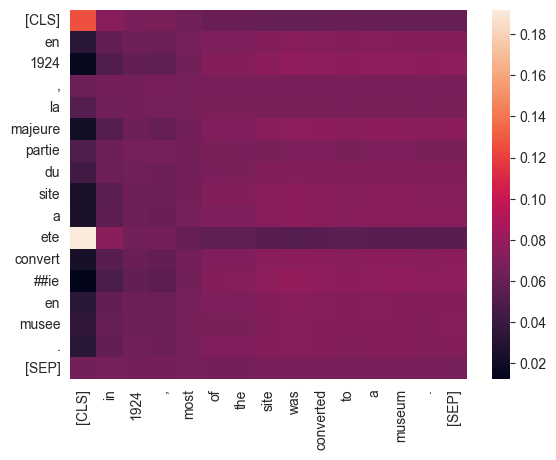

In [146]:
sns.heatmap(data=attention_frame)

plt.show()

## Transformer model

In [15]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Encoder, self).__init__()

        self.layers = torch.nn.Sequential()
        
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention1 = torch.nn.MultiheadAttention(emb_dim, 1)
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.attention2 = torch.nn.MultiheadAttention(hidden_dim, 1)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)


    def forward(self, input):
        r'''
        :param input: tensor batch_size x seq_len --- list of tokens

        '''
        input = input.transpose(0, 1)
        act = self.embedding(input)
        act, _ = self.attention1(act, act, act)
        act = self.relu(act)
        act = self.linear1(act)
        act = self.relu(act)
        act, _ = self.attention2(act, act, act)
        act = self.relu(act)
        act = self.linear2(act)
        return act.transpose(0, 1)

In [16]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_dim)
        self.attention1 = torch.nn.MultiheadAttention(emb_dim, 1)
        self.linear1 = torch.nn.Linear(emb_dim, hidden_dim)
        self.relu = torch.nn.ReLU()

        self.attention2 = torch.nn.MultiheadAttention(hidden_dim, 1)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)

        self.linear = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, input, encoder_outputs):
        r'''
        :param input: tensor batch_size x seq_len
        '''
        input = input.transpose(0, 1)
        act = self.embedding(input)

        act, _ = self.attention1(act, 
                                encoder_outputs.transpose(0, 1), 
                                encoder_outputs.transpose(0, 1))
        
        act = self.relu(act)
        act = self.linear1(act)
        act = self.relu(act)
        act, _ = self.attention2(act, 
                                 encoder_outputs.transpose(0, 1), 
                                 encoder_outputs.transpose(0, 1))
        act = self.relu(act)
        act = self.linear2(act)

        return self.linear(act).transpose(0, 1)

In [17]:
class Seq2SeqAttn(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, vocab_size, emb_dim=30, hidden_dim=30):
        super(Seq2SeqAttn, self).__init__()
        self.vocab_size = vocab_size
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim)

    def forward(self, input, decoder_input=None, max_seq_len=64):
        r'''
        '''
        encoder_output = self.encoder(input)

        if decoder_input is None:
            translated_scores = torch.zeros(len(input), 
                                            max_seq_len, 
                                            self.vocab_size).to(self.device)
            translated_scores[:, 0, input[:, 0]] = 1.
            for i in range(1, max_seq_len):
                translated_scores[:, i:i+1] = self.decoder(
                    torch.argmax(translated_scores, axis=-1), 
                    encoder_output)[:, i:i+1]
        else:
            translated_scores = self.decoder(
                decoder_input, encoder_output)

        return translated_scores


### Initialization

In [14]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased',
                                          verbose=False)
print(f"Vocab size: {tokenizer.vocab_size}")

en_texts_tensors = tokenizer(en_texts[:20000],
                             return_tensors='pt', max_length=64, padding=True)
fr_texts_tensors = tokenizer(fr_texts[:20000],
                             return_tensors='pt', max_length=64, padding=True)

# actually not ok to include whole dataset in memory, better to write batch_generator
dataset_train_pt = torch.utils.data.TensorDataset(
    en_texts_tensors['input_ids'][:19000], fr_texts_tensors['input_ids'][:19000])
dataset_test_pt = torch.utils.data.TensorDataset(
    en_texts_tensors['input_ids'][19000:], fr_texts_tensors['input_ids'][19000:])

Vocab size: 105879


In [27]:
model = Seq2SeqAttn(tokenizer.vocab_size)
model.to(device)

Seq2SeqAttn(
  (encoder): Encoder(
    (layers): Sequential()
    (embedding): Embedding(105879, 30)
    (attention1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (relu): ReLU()
    (attention2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear2): Linear(in_features=30, out_features=30, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(105879, 30)
    (attention1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (relu): ReLU()
    (attention2): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=30, out_features=30, bias=True)
    )
    (linear2): Linear(in_features=30, out_feat

In [28]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_fr = tokenizer(['en 1924, la majeure partie du site a été convertie en musée.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device), 
              tokens_fr['input_ids'].to(model.device)),
        axis=-1)
tokenizer.decode(answer[0])

'גביע גביע גביע גביע גביע גביע גביע גביע גביע גביע גביע גביע גביע גביע גביע גביע גביע'

In [29]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam

In [30]:
trainer(count_of_epoch=2,
        batch_size=128,
        dataset=dataset_train_pt,
        model=model, 
        loss_function=loss_function,
        optimizer = optimizer,
        lr=0.001,
        callback=None)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


epoch:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

In [31]:
tokens_en = tokenizer(['in 1924, most of the site was converted to a museum.'], return_tensors='pt')
tokens_fr = tokenizer(['en 1924, la majeure partie du site a été convertie en musée.'], return_tensors='pt')
with torch.no_grad():
    answer = torch.argmax(
        model(tokens_en['input_ids'].to(model.device),
              tokens_fr['input_ids'].to(model.device)),
        axis=-1)
tokenizer.decode(answer[0])

'[SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP] [SEP]'

## Tensor2Tensor translator

In [2]:
!pip install sentencepiece


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [15]:
from transformers import MarianTokenizer, MarianMTModel

tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-fr-en')
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-fr-en')
model.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [16]:
batch_x = tokenizer.prepare_seq2seq_batch(src_texts=["Bonjour tout le monde, je m'appelle Transformer"], return_tensors="pt")

In [17]:
tokenizer.batch_decode(model.generate(**batch_x.to(device)))

['<pad> Hello, everybody, my name is Transformer.</s>']

## BPE tokenization (Byte Pair Encoding)

In [18]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE', 
                                          verbose=False)
tokenizer.vocab_size

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

501153

In [19]:
tokenizer.tokenize('Hello Mathematic, my Name is Alex, how are you?')

['Hello',
 'Math',
 '##emat',
 '##ic',
 ',',
 'my',
 'Name',
 'is',
 'Alex',
 ',',
 'how',
 'are',
 'you',
 '?']

## BERT (Bidirectional Encoder Representations from Transformers)

In [20]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased', 
                                          verbose=False)
model = AutoModel.from_pretrained('bert-base-multilingual-cased')
model.to(device)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

### BERT Architecture
It is conditionally divided into three parts:

- Tokens Embedding
- Self-Attention
- Pooler — creates embedding of the entire sentence from token embeddings

### Mathematical Model of BERT
Let's define a set of tokens:
$$
\mathcal{I} = \{\mathbf{i}| \mathbf{i} = [0, \cdots, 0, 1, 0,  \cdots, 0]^{\mathsf{T}}\}
$$

Given a set of sentences and a set of token types in a sentence:
$$
\mathcal{S} = \mathcal{I}^n, \quad \mathcal{T} = \{[0,1]^{\mathsf{T}}, [1,0]^{\mathsf{T}}\}^n
$$

Mappings:
$$
BM_1: \mathbb{R}^{n\times L}\times \mathbb{R}^{n\times 2} \to \mathbb{R}^{n \times l}
$$ — word embeddings
$$
BM_2: \mathbb{R}^{n\times L}\times \mathbb{R}^{n\times 2} \to \mathbb{R}^{1 \times l}
$$ — embedding of the entire sentence

Superposition of mappings:
$$
BM_1 = BL_m \circ \cdots \circ BL_1 \circ BSE
$$
$$
BM_2 = BP \circ BL_m \circ \cdots \circ BL_1 \circ BSE
$$

### Mathematical Model of BERT: Bert Sequence Embedding (BSE)

The function $BSE$:
$$
BSE:\mathbb{R}^{n\times L} \times \mathbb{R}^{n\times 2} \to \mathbb{R}^{n\times l}.
$$

For an arbitrary matrix $\mathbf{s} \in \mathcal{S} \subset \mathbb{R}^{n\times L}$ and matrix $\mathbf{t} \in \mathcal{T}\subset \mathbb{R}^{n\times 2}$, the mapping $BSE$ takes the following form:
$$
BSE\bigr(\mathbf{s}, \mathbf{t}\bigr) = \frac{\mathbf{h}_{bse} - \mathsf{E}\mathbf{h}_{bse}}{\sqrt{\mathsf{D}\mathbf{h}_{bse}+\varepsilon}}\cdot\textbf{w}_1 + \textbf{w}_2, \quad \mathbf{h}_{bse} = \mathbf{s}\mathbf{W}_1 + \mathbf{1}_{n\times n}\mathbf{W}_2 + \mathbf{t}\mathbf{W}_3,
$$
where $\mathbf{W}_1 \in \mathbb{R}^{L\times l},~\mathbf{W}_2 \in \mathbb{R}^{n\times l},~\mathbf{W}_3 \in \mathbb{R}^{2\times l}.$

The function $BSE$ has tunable parameters: $\mathbf{W}_1, \mathbf{W}_2, \mathbf{W}_3, \mathbf{w}_1, \mathbf{w}_2.$

Let's denote the output of function $BSE$ as:
$$
\mathbf{h}_0 = BSE\bigr(\mathbf{s}, \mathbf{t}\bigr),
$$
where $\mathbf{h} \in \mathbb{R}^{n\times l}.$

### Mathematical Model of BERT: BertLayer (BL)

The function $BL$:
$$
    BL: \mathbb{R}^{n\times l} \to \mathbb{R}^{n\times l}.
$$
For matrix $\mathbf{h} \in \mathbb{R}^{n\times l}$ BL takes the following form:
$$
    BL_q\bigr(\mathbf{h}\bigr) = \frac{\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a} - \mathsf{E}\left(\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a}\right)}{\sqrt{\mathsf{D}\left(\mathbf{u}\mathbf{W}_{3+6q} + \mathbf{a}\right)+\varepsilon}}\cdot\textbf{w}_{3+4q} + \textbf{w}_{4+4q},
$$
$$
\mathbf{u} = \sigma\bigr(\mathbf{a}\mathbf{W}_{4+6q}\bigr), \quad \mathbf{a} = \frac{\mathbf{c}\mathbf{W}_{5+6q} - \mathsf{E}\mathbf{c}\mathbf{W}_{5+6q}}{\sqrt{\mathsf{D}\mathbf{c}\mathbf{W}_{5+6q}+\varepsilon}}\cdot\textbf{w}_{5+4q} + \textbf{w}_{6+4q}
$$
$$
\mathbf{c} = [\mathbf{c}_1, \cdots \mathbf{c}_{J}]
$$
$$
\mathbf{c}_j = \text{softmax}\bigr(\mathbf{h}\mathbf{W}^{j}_{6+6q}\odot\mathbf{h}\mathbf{W}^{j}_{7+6q}\bigr)\odot\mathbf{h}\mathbf{W}^{j}_{8+6q}
$$
where for all $q$ matrices $\mathbf{W}^{j}_{6+6q}, \mathbf{W}^{j}_{7+6q}, \mathbf{W}^{j}_{8+6q} \in \mathbb{R}^{l \times r}$, for all $j$ matrices $\mathbf{c}_j \in \mathbb{R}^{n\times r}$, for all $q$ matrices $\mathbf{W}^{j}_{5+6q} \in \mathbb{R}^{l \times l}, \mathbf{W}^{j}_{4+6q} \in \mathbb{R}^{l \times p}, \mathbf{W}^{j}_{3+6q} \in \mathbb{R}^{p \times l}$, matrix $\mathbf{c}, \mathbf{a} \in \mathbb{R}^{n \times l}$, matrix $\mathbf{u} \in \mathbb{R}^{n \times p}$.

$$ J \cdot r = l$$

Tunable parameters: $\mathbf{W}^{j}_{3+6q}, \mathbf{W}^{j}_{4+6q}, \mathbf{W}^{j}_{5+6q}, \mathbf{W}^{j}_{6+6q}, \mathbf{W}^{j}_{7+6q}, \mathbf{W}^{j}_{8+6q}, \textbf{w}_{3+4q}, \textbf{w}_{4+4q}, \textbf{w}_{5+4q}, \textbf{w}_{6+4q}$

The output of function $BL_q$:
$$
\forall q \in \{1, \dots, m\} \quad \mathbf{h}_{q} = BL_q\bigr(\mathbf{h}_{q-1}\bigr).
$$

### Mathematical Model of BERT: BertPooler (BP)

The function $BP$:
$$
    BP: \mathbb{R}^{n\times l} \to \mathbb{R}^{n\times l}.
$$
For matrix $\mathbf{h}_{m} \in \mathbb{R}^{n \times l}$ BP takes the following form:
$$
BP\bigr(\mathbf{h}_{m}\bigr) = \tanh\bigr(\mathbf{h}_m^{1}\mathbf{W}_{9+6m}\bigr),
$$
where $\mathbf{h}_m^{1}$ is the first row of matrix $\mathbf{h}_{m}$, and matrix $\mathbf{W}_{9+6m} \in \mathbb{R}^{l\times l}$

The function $BP$ has tunable parameters $\mathbf{W}_{9+6m}$

The output of function $BP$:
$$
\mathbf{h} = BP\bigr(\mathbf{h}_m\bigr).
$$

### Back to Superposition

Let's return to superpositions $BM_1, BM_2$:
$$
\mathbf{h} = BP\bigr(\mathbf{h}_m\bigr), \quad\mathbf{h}_q = BM\bigr(\mathbf{h}_{q-1} \bigr), \quad \mathbf{h}_0 = BSE\bigr(\mathbf{s}, \mathbf{t}\bigr)
$$

We get the word embeddings vector:
$$
BM_1\bigr(\mathbf{s}, \mathbf{t}\bigr) = \mathbf{h}_m,
$$
We get the sentence embedding vector:
$$
BM_2\bigr(\mathbf{s}, \mathbf{t}\bigr) = \mathbf{h}
$$

### Back to Superposition

Let's return to superpositions $BM_1, BM_2$:
$$
\mathbf{h} = BP\bigr(\mathbf{h}_m\bigr), \quad\mathbf{h}_q = BM\bigr(\mathbf{h}_{q-1} \bigr), \quad \mathbf{h}_0 = BSE\bigr(\mathbf{s}, \mathbf{t}\bigr)
$$

We get the word embeddings vector:
$$
BM_1\bigr(\mathbf{s}, \mathbf{t}\bigr) = \mathbf{h}_m,
$$
We get the sentence embedding vector:
$$
BM_2\bigr(\mathbf{s}, \mathbf{t}\bigr) = \mathbf{h}
$$

In [21]:
tokens = tokenizer(['Hello World', 'Alex Avdiushenko'], return_tensors='pt', padding=True)

with torch.no_grad():
    output = model(**tokens.to(device))

In [23]:
print(tokens['input_ids'])

tensor([[   101,  31178,  10315,    102,      0,      0,      0],
        [   101,  14728,  33799, 106254,  14786,  10440,    102]],
       device='mps:0')


In [24]:
output[0].shape, output[1].shape

(torch.Size([2, 7, 768]), torch.Size([2, 768]))

In [25]:
tokens

{'input_ids': tensor([[   101,  31178,  10315,    102,      0,      0,      0],
        [   101,  14728,  33799, 106254,  14786,  10440,    102]],
       device='mps:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]], device='mps:0')}

## LaBSE Model (Language-agnostic BERT Sentence Embedding)

July 2020 https://arxiv.org/abs/2007.01852

The model uses triplet loss for translations of the same sentence (and non-translations accordingly).

Key aspects of LaBSE:
- Built on multilingual BERT architecture
- Uses parallel sentences from different languages as training data
- Employs triplet loss function to:
  - Bring embeddings of translations closer together
  - Push embeddings of non-translations further apart
- Language-agnostic: Can generate comparable embeddings across different languages
- Enables cross-lingual similarity comparisons and retrieval

In [26]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE', 
                                          verbose=False)
model = AutoModel.from_pretrained('sentence-transformers/LaBSE')
model.to(device)

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(501153, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [27]:
tokens = tokenizer(['Neapolis University Pafos',
                    'Университет Неаполис в Пафосе',
                    'Санкт-Петербургский Государственный Университет', 
                    'Saint Petersburg State University'], 
                   return_tensors='pt', padding=True)

with torch.no_grad():
    output = model(**tokens.to(device))

sentence_embeding = output[1].cpu().numpy()

In [28]:
sentence_embeding.shape

(4, 768)

In [29]:
frame = pd.DataFrame(np.round(
    scipy.spatial.distance.cdist(sentence_embeding, sentence_embeding, 
                                 metric='cosine'), 2))


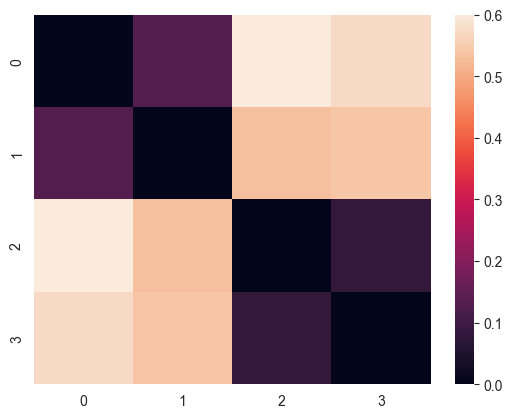

In [30]:
sns.heatmap(data=frame)

plt.show()